# 🛡️ LOGISTIC REGRESSION WITH REGULARIZATION

## WHAT IS REGULARIZATION?
- IN REAL-WORLD MACHINE LEARNING, MODELS DO NOT FAIL BECAUSE THEY ARE TOO SIMPLE, THEY FAIL BECAUSE THEY **LEARN TOO MUCH**.
- THIS PHENOMENON IS CALLED **OVERFITTING**.
- REGULARIZATION IS A TECHNIQUE USED TO PREVENT **OVERFITTING** BY PENALIZING LARGE WEIGHTS ($\theta$).
- IT ADDS A `"COMPLEXITY TERM"` TO THE COST FUNCTION, FORCING THE MODEL TO KEEP PARAMETERS SMALL AND SIMPLE.

> OVERFITTING OCCURS WHEN A MODEL:
- MEMORIZES TRAINING DATA
- LEARNS NOISE INSTEAD OF PATTERNS
- PERFORMS WELL ON TRAIN DATA BUT FAILS ON UNSEEN DATA

> REGULARIZATION IS A **CONTROL MECHANISM** THAT:
- PENALIZES LARGE WEIGHTS
- LIMITS MODEL COMPLEXITY
- IMPROVES GENERALIZATION
- INTRODUCES BIAS TO REDUCE VARIANCE

LOGISTIC REGRESSION LEARNS PARAMETERS BY MINIMIZING A COST FUNCTION.

WITHOUT REGULARIZATION:

## REGULARIZATION IN LOGISTIC REGRESSION

COST FUNCTION WITHOUT REGULARIZATION 

    J(θ) = -(1/m) Σ [y·log(hθ(x)) + (1 − y)·log(1 − hθ(x))]

### THE THREE TYPES WE WILL IMPLEMENT:

> **1. L2 REGULARIZATION (RIDGE)**
> * **PENALTY:** SQUARED MAGNITUDE OF WEIGHTS ($\theta_j^2$).
> * **EFFECT:** SHRINKS ALL COEFFICIENTS TOWARDS ZERO EVENLY. GOOD FOR COLLINEARITY. SMOOTH DECISION BOUNDARY
> * **MATH:**
>   $$J(\theta)_{reg} = J(\theta) + \frac{\lambda}{2m} \sum_{j=1}^{n} \theta_j^2$$

> **2. L1 REGULARIZATION (LASSO)**
> * **PENALTY:** ABSOLUTE VALUE OF WEIGHTS ($|\theta_j|$).
> * **EFFECT:** CAN SHRINK COEFFICIENTS TO EXACTLY ZERO. PERFORMS **FEATURE SELECTION**. CREATES SPARSE MODELS.
> * **MATH:**
>   $$J(\theta)_{reg} = J(\theta) + \frac{\lambda}{m} \sum_{j=1}^{n} |\theta_j|$$

> **3. ELASTIC NET**
> * **PENALTY:** A COMBINATION OF BOTH L1 AND L2.
> * **EFFECT:** BALANCES SPARSITY (L1) AND STABILITY (L2).
> * **MATH:**
>   $$J(\theta)_{reg} = J(\theta) + r \cdot (\text{L1}) + (1-r) \cdot (\text{L2})$$

---
`NOTE`: WE DO NOT REGULARIZE THE BIAS TERM ($\theta_0$). REGULARIZATION IS APPLIED **ONLY TO WEIGHTS.**

## IMPORTING LIBRARIES
WE WILL USE ONLY NUMPY, PANDAS, AND MATPLOTLIB/SEABORN.

In [1]:
# IMPORT NUMERICAL COMPUTATION LIBRARY
import numpy as np

# IMPORT DATA HANDLING LIBRARY
import pandas as pd

# IMPORT VISUALIZATION LIBRARIES
import matplotlib.pyplot as plt
import seaborn as sns

## VISUALIZATION STYLE

In [2]:
# SETTING UP THE VISUALIZATION STYLE GLOBALLY TO MATCH YOUR REQUIRED FORMAT
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['figure.dpi'] = 500
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'

## LOADING DATA
READING THE DATA FROM CSV FILES.

In [3]:
# LOADING DATA
# IF HEADERS EXIST, REMOVE 'header=None'.

# LOAD X DATA FROM CSV FILE
X_raw = pd.read_csv('DATA/logisticX.csv', header=None).values

# LOAD Y DATA FROM CSV FILE
y_raw = pd.read_csv('DATA/logisticY.csv', header=None).values

In [4]:
# RESHAPING Y TO ENSURE IT IS A COLUMN VECTOR (M, 1)
y_data = y_raw.reshape(-1, 1)

# CHECKING SHAPE
print(f"X SHAPE --> {X_raw.shape}")
print(f"Y SHAPE --> {y_data.shape}")

X SHAPE --> (100, 2)
Y SHAPE --> (100, 1)


## PREPROCESSING DATA
WE WILL NORMALIZE THE DATA AND ADD AN INTERCEPT TERM (BIAS) TO X.

In [5]:

# NORMALIZATION (MIN-MAX SCALING)
# THIS IS CRUCIAL FOR GRADIENT DESCENT CONVERGENCE
# MATH: X_norm = (X - min) / (max - min)

X_min = np.min(X_raw, axis = 0)
X_max = np.max(X_raw, axis = 0)
X_norm = (X_raw - X_min) / (X_max - X_min)

In [6]:
# ADDING INTERCEPT TERM (COLUMN OF ONES) TO X
# MATH: X = [1, x1, x2, ...]

m = len(y_data)
X_data = np.hstack((np.ones((m, 1)), X_norm))

print(f"PROCESSED X SHAPE: {X_data.shape}")

PROCESSED X SHAPE: (100, 3)


## REGULARIZED LOGISTIC REGRESSION CLASS
THIS CLASS HANDLES L1, L2, AND ELASTIC NET.

`KEY UPDATES FROM PREVIOUS CODE`
- **COST FUNCTION:** ADDED PENALTY TERMS.
- **GRADIENT:** ADDED DERIVATIVE OF PENALTIES.
    * DERIVATIVE OF $\theta^2$ IS $2\theta$.
    * DERIVATIVE OF $|\theta|$ IS $\text{sgn}(\theta)$.

In [10]:
class RegularizedLogisticRegression:
    def __init__(self, learning_rate = 0.5, iterations = 1000, penalty = 'None', lambda_ = 0.1, l1_ratio = 0.5):
        self.lr = learning_rate
        self.iter = iterations
        self.penalty = penalty        # 'none', 'l1', 'l2', 'elasticnet'
        self.lambda_ = lambda_        # REGULARIZATION STRENGTH
        self.l1_ratio = l1_ratio      # FOR ElasticNet (0=L2, 1=L1)
        self.theta = None
        self.cost_history = []
        
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def cost_function(self, X, y):
        m = len(y)
        h = self.sigmoid(np.dot(X, self.theta))
        epsilon = 1e-15
        
        # BASIC LOG LOSS
        cost = -(1 / m) * np.sum(y * np.log(h + epsilon) + (1 - y) * np.log(1 - h + epsilon))
        
        # REGULARIZATION TERM (EXCLUDING BIAS theta[0])
        # WE SLICE theta[1:] BECAUSE WE DON'T PENALIZE BIAS
        
        theta_noBias = self.theta[1:]
        penalty_term = 0
        
        if self.penalty == 'L2':
            penalty_term = (self.lambda_ / (2 * m)) * np.sum(np.square(theta_noBias))
        
        elif self.penalty == 'L1':
            penalty_term = (self.lambda_ / m) * np.sum(np.abs(theta_noBias))
       
        elif self.penalty == 'ElasticNet':
            L1 = np.sum(np.abs(theta_noBias))
            L2 = np.sum(np.square(theta_noBias))
            
            # SKLEARN STYLE MIX: r * L1 + (1-r) * L2 (SCALED BY LAMBDA)
            penalty_term = (self.lambda_ / m) * (self.l1_ratio * L1 + (1 - self.l1_ratio) *  0.5 * L2)
            
        return cost + penalty_term
    
    def train(self, X, y):
        self.theta = np.zeros((X.shape[1], 1))    
        self.cost_history = []
        m = len(y)
        
        for i in range(self.iter):
            #  HYPOTHESIS
            h = self.sigmoid(np.dot(X, self.theta))
            
            # BASIC GRADIENT (BASE_GRAD)
            # dJ/dTheta = (1/m) * X.T * (h - y)
            gradient = (1 / m) * np.dot((X.T), (h - y))
            
            # ADDING REGULARIZATION TO GRADIENT
            # WE CREATE A COPY OF THETA AND SET BIAS TO 0 SO IT DOESN'T GET PENALIZED
            theta_reg = self.theta.copy()
            theta_reg[0] = 0
            
            if self.penalty == 'L2':
                # DERIVATIVE OF (lambda/2m * sum(theta^2)) -> (lambda/m) * theta
                gradient += (self.lambda_ / m) * theta_reg
            
            elif self.penalty == 'L1':
                # DERIVATIVE OF (lambda/m * sum|theta|) -> (lambda/m) * sign(theta)
                gradient += (self.lambda_ / m) * np.sign(theta_reg)
            
            elif self.penalty == 'ElasticNet':
                L1 = np.sign(theta_reg)
                L2 = theta_reg
                gradient += (self.lambda_ / m) * (self.l1_ratio * L1 + (1 - self.l1_ratio) * L2)
                
            # UPDATE
            self.theta -= (self.lr * gradient)
            self.cost_history.append(self.cost_function(X, y))
            
            # if i % 100 == 0:
            #     print(f"ITERATION {i} | COST: {self.cost_function(X, y):.6f}") 
                
    def predict_proba(self, X):
        return self.sigmoid(np.dot(X, self.theta))
    
    def predict(self, X, threshold = 0.5):
        return (self.predict_proba(X) >= threshold).astype(int)            

# 🧮 WHY THE 0.5 MULTIPLIER IN 

> `penalty_term = (self.lambda_ / m) * (self.l1_ratio * L1 + (1 - self.l1_ratio) *  0.5 * L2)`?

### 1. THE "GRADIENT CANCELLATION" TRICK
THE PRIMARY REASON IS **CALCULUS CONVENIENCE**.

WHEN WE OPTIMIZE OUR MODEL, WE NEED TO FIND THE **DERIVATIVE** (GRADIENT) OF THE COST FUNCTION WITH RESPECT TO THE WEIGHTS ($\theta$).

> **WITHOUT THE 0.5:**
> IF THE L2 TERM IS SIMPLY $\theta^2$:
> $$\frac{d}{d\theta}(\theta^2) = 2\theta$$
> THIS INTRODUCES AN EXTRA FACTOR OF **2** INTO OUR GRADIENT UPDATES, WHICH WE WOULD HAVE TO CARRY AROUND.

> **WITH THE 0.5:**
> IF WE DEFINE THE L2 TERM AS $\frac{1}{2}\theta^2$:
> $$\frac{d}{d\theta}\left(\frac{1}{2}\theta^2\right) = \frac{1}{2} \cdot 2\theta = \theta$$
> THE **2** AND THE **1/2** CANCEL EACH OTHER OUT PERFECTLY! 

THIS LEAVES US WITH A CLEANER GRADIENT: JUST THE WEIGHTS THEMSELVES ($\theta$).

---

### 2. CONSISTENCY WITH SCIKIT-LEARN
SINCE WE AIM TO COMPARE OUR RESULTS WITH SCIKIT-LEARN, WE MUST MATCH THEIR MATHEMATICAL DEFINITION.

SCIKIT-LEARN DEFINES THE ELASTIC NET COST FUNCTION AS:

$$J(\theta) = \text{LogLoss} + \alpha \cdot \rho \cdot ||\theta||_1 + \frac{\alpha \cdot (1-\rho)}{2} \cdot ||\theta||_2^2$$

* $\alpha$ (Alpha) corresponds to `lambda_`
* $\rho$ (Rho) corresponds to `l1_ratio`
* NOTICE THE **DIVISION BY 2** IN THE L2 TERM.

### 3. VERIFYING THE CODE MATCH
LOOK AT HOW THIS AFFECTS OUR **GRADIENT CALCULATION** IN THE `train` METHOD:

**IN COST FUNCTION:**
```python
# WE ADD THE 0.5 HERE
penalty_term = ... + (1 - self.l1_ratio) * 0.5 * l2_term
```

### IN GRADIENT CALCULATION:
```python
# WE DO NOT MULTIPLY BY 2 HERE. WE JUST USE theta_reg DIRECTLY.
# BECAUSE DERIVATIVE OF 0.5*theta^2 IS JUST theta.
L2 = theta_reg
gradient += ... + (1 - self.l1_ratio) * L2
```

> IF WE HAD REMOVED THE 0.5 FROM THE COST FUNCTION, WE WOULD HAVE NEEDED TO WRITE `2 * L2` IN THE GRADIENT CODE.

## COMPARING MODELS: L1 VS L2 VS NONE
WE WILL TRAIN THREE MODELS WITH THE SAME LEARNING RATE BUT DIFFERENT REGULARIZATION TECHNIQUES.

WE USE A HIGH `LAMBDA` (REGULARIZATION STRENGTH) TO MAKE THE EFFECTS VISIBLE.

In [16]:
# HYPERPARAMETERS
LR = 0.5
ITER = 1000
# STRONG REGULARIZATION TO SHOW EFFECT
LAMBDA_VAL = 2.0

# NO REGULARIZATION
model_None = RegularizedLogisticRegression(LR, ITER, penalty = 'None')
model_None.train(X_data, y_data)

# L2 (RIDGE)
model_L2 = RegularizedLogisticRegression(LR, ITER, penalty='L2', lambda_=LAMBDA_VAL)
model_L2.train(X_data, y_data)

# L1 (LASSO)
model_L1 = RegularizedLogisticRegression(LR, ITER, penalty='L1', lambda_=LAMBDA_VAL)
model_L1.train(X_data, y_data)

# PRINTING COEFFICIENTS TO SEE SHRINKAGE
print("--- COEFFICIENT COMPARISON ---")
print(f"{'REGULARIZATION':<20} {'THETA_0 (BIAS)':<15} {'THETA_1':<15} {'THETA_2':<15}")
print("-" * 60)
print(f"{'NONE':<20} {model_None.theta[0,0]:<15.4f} {model_None.theta[1,0]:<15.4f} {model_None.theta[2,0]:<15.4f}")
print(f"{'L2':<20} {model_L2.theta[0,0]:<15.4f} {model_L2.theta[1,0]:<15.4f} {model_L2.theta[2,0]:<15.4f}")
print(f"{'L1':<20} {model_L1.theta[0,0]:<15.4f} {model_L1.theta[1,0]:<15.4f} {model_L1.theta[2,0]:<15.4f}")

--- COEFFICIENT COMPARISON ---
REGULARIZATION       THETA_0 (BIAS)  THETA_1         THETA_2        
------------------------------------------------------------
NONE                 0.3804          8.2186          -7.9268        
L2                   0.2268          1.8947          -2.1675        
L1                   0.4268          3.9379          -4.3647        


## VISUALIZING THE EFFECT ON DECISION BOUNDARY
REGULARIZATION SHOULD PREVENT THE MODEL FROM FITTING EXTREME OUTLIERS, OFTEN RESULTING IN A "LESS STEEP" OR MORE CENTRALIZED BOUNDARY.

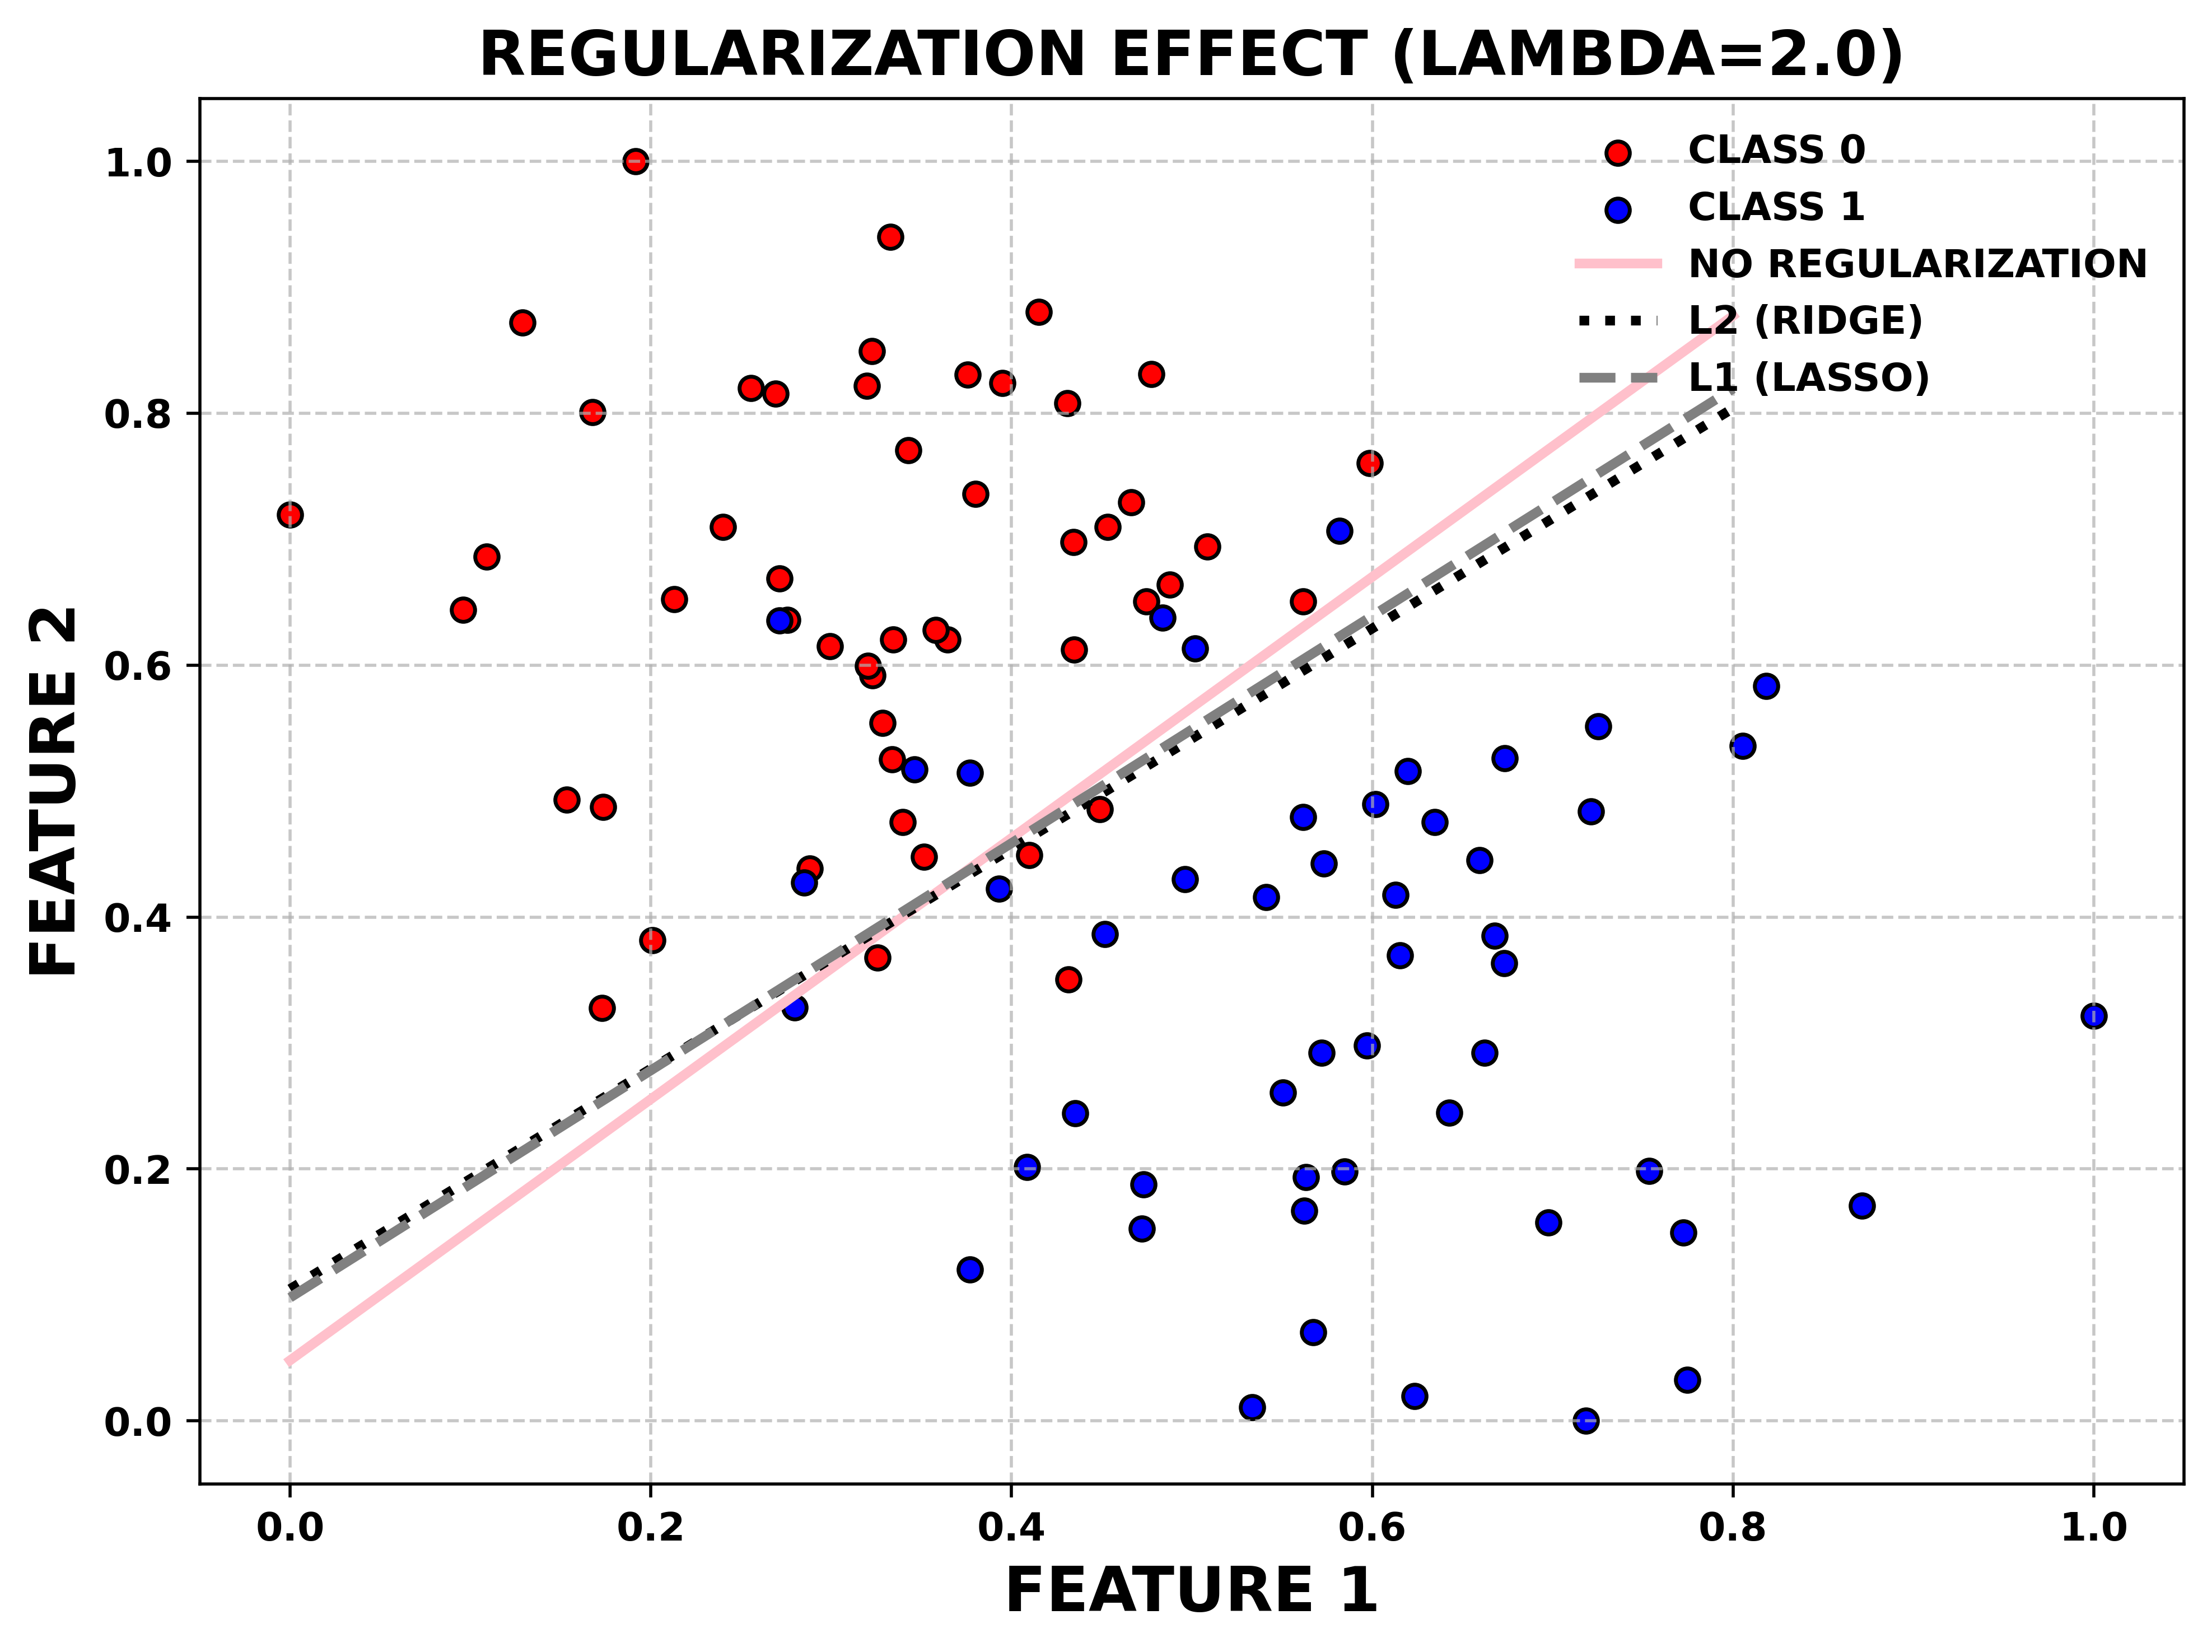

In [24]:
plt.figure(figsize=(8, 6), dpi=500)

# SCATTER PLOT
mask_0 = (y_data.flatten() == 0)
mask_1 = (y_data.flatten() == 1)
plt.scatter(X_norm[mask_0, 0], X_norm[mask_0, 1], color='red', edgecolor='black', label="CLASS 0")
plt.scatter(X_norm[mask_1, 0], X_norm[mask_1, 1], color='blue', edgecolor='black', label="CLASS 1")

# PLOTTING BOUNDARIES
x_vals = np.linspace(0, 0.8, 100)

models = [model_None, model_L2, model_L1]
labels = ['NO REGULARIZATION', 'L2 (RIDGE)', 'L1 (LASSO)']
colors = ['pink', 'black', 'grey']
styles = ['solid' , 'dotted', 'dashed']

for model_obj, label, col, style in zip(models, labels, colors, styles):
    theta = model_obj.theta
    # x2 = -(theta0 + theta1*x1) / theta2
    y_vals = -(theta[0] + theta[1] * x_vals) / theta[2]
    
    plt.plot(x_vals, y_vals, color=col, linestyle=style, linewidth=2.5, label=label)

plt.title(f"REGULARIZATION EFFECT (LAMBDA={LAMBDA_VAL})", fontsize=16, fontweight='bold')
plt.xlabel("FEATURE 1", fontsize=16, fontweight='bold')
plt.ylabel("FEATURE 2", fontsize=16, fontweight='bold')

for label in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    label.set_fontweight('bold')

plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper right', fontsize=12, frameon=False, prop={'weight': 'bold'})
plt.tight_layout()
plt.show()